In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import transformers
from transformers import BertForSequenceClassification, BertTokenizerFast, AdamW

# specify GPU
device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv("/content/drive/My Drive/train.csv")
data_valid = pd.read_csv("/content/drive/My Drive/test.csv")

# Split into TRAIN / TEST set

In [5]:
train_text, test_text, train_labels, test_labels = train_test_split(data['text'], data['target'], 
                                                                    random_state=66, 
                                                                    test_size=0.1)
print(f"Train has {len(train_text)} samples")
print()
print(f"Test has {len(test_text)} samples")

Train has 6851 samples

Test has 762 samples


# Import Tokenizer

In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased-whole-word-masking')

# Tokenization

In [7]:
max_seq_len = 60


# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Converting to PyTorch Data Types (Tensor)

In [8]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Training our model

## The Bert Model For Sequence Classification

In [10]:
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased-whole-word-masking", 
    num_labels = 2, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

## Some utils functions

In [13]:
# Save and Load Functions

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Optimizer & Learning Rate Scheduler

In [14]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Our training function (loop)

In [15]:
# Training Function

def train(model,
          optimizer,
          scheduler=scheduler,
          train_loader = train_dataloader,
          valid_loader = val_dataloader,
          num_epochs = epochs,
          file_path = None,
          best_valid_loss = float("Inf")):
    
    # For reproductibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    eval_accuracy = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
      # iterate over batches
      for step,batch in enumerate(train_loader):
        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        # PyTorch doesn't do this automatically
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        loss, _ = outputs
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        running_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

      global_step += 1

      # evaluation step
      model.eval()
      # Evaluate data for one epoch
      for batch in valid_loader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():                    
          output = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
          loss, _ = output
          valid_running_loss += loss.item()


          # Forward pass, calculate logit predictions.
          # This will return the logits rather than the loss because we have
          # not provided labels.
          # token_type_ids is the same as the "segment ids", which 
          # differentiates sentence 1 and 2 in 2-sentence tasks.
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask)
        
          # Get the "logits" output by the model. The "logits" are the output
          # values prior to applying an activation function like the softmax.
          logits = outputs[0]
          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
        
          # Calculate the accuracy for this batch of test sentences.
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
          # Accumulate the total accuracy.
          eval_accuracy += tmp_eval_accuracy
      # evaluation
      average_train_loss = running_loss / len(train_loader)
      average_valid_loss = valid_running_loss / len(valid_loader)
      train_loss_list.append(average_train_loss)
      valid_loss_list.append(average_valid_loss)
      global_steps_list.append(global_step)

      # resetting running values
      running_loss = 0.0                
      valid_running_loss = 0.0
      # Report the final accuracy for this validation run.
      print(f"Validation Accuracy: {eval_accuracy/global_step}")
      model.train()

      # print progress
      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss}, Valid Loss: {average_valid_loss}')
                
      # checkpoint
      if best_valid_loss > average_valid_loss:
        best_valid_loss = average_valid_loss
        save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
        save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

optimizer = AdamW(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, file_path="/content/drive/My Drive/")

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Validation Accuracy: 39.775
Epoch [1/4], Train Loss: 0.4494505514909615, Valid Loss: 0.45404368328551453
Model saved to ==> /content/drive/My Drive//model.pt
Model saved to ==> /content/drive/My Drive//metrics.pt
Validation Accuracy: 38.993750000000006
Epoch [2/4], Train Loss: 0.3715378373062416, Valid Loss: 0.5389387781421343
Validation Accuracy: 38.900000000000006
Epoch [3/4], Train Loss: 0.31741957341283905, Valid Loss: 0.5997336654302975
Validation Accuracy: 39.118750000000006
Epoch [4/4], Train Loss: 0.2672204338383181, Valid Loss: 0.5112070254981518
Model saved to ==> /content/drive/My Drive//metrics.pt
Finished Training!


## Diagram of the training's evolution

Model loaded from <== /content/drive/My Drive//metrics.pt


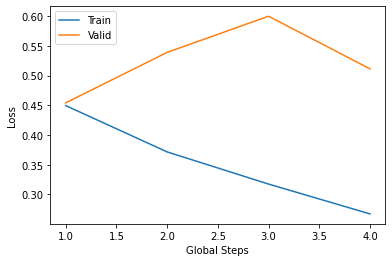

In [16]:
import matplotlib.pyplot as plt
train_loss_list, valid_loss_list, global_steps_list = load_metrics( '/content/drive/My Drive/' 
                                                                   + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Model Evaluation 

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== /content/drive/My Drive//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8070    0.7846    0.7956       325
           0     0.8430    0.8604    0.8516       437

    accuracy                         0.8281       762
   macro avg     0.8250    0.8225    0.8236       762
weighted avg     0.8277    0.8281    0.8278       762



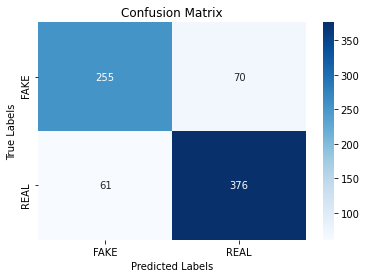

In [17]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)
          # Unpack the inputs from our dataloader
          b_input_ids, b_input_mask, b_labels = batch
          output = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask)

          output = output[0]
          y_pred.extend(torch.argmax(output, 1).tolist())
          y_true.extend(b_labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
best_model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased-whole-word-masking").to(device)

load_checkpoint('/content/drive/My Drive/' + '/model.pt', best_model)

evaluate(best_model, val_dataloader)

In [18]:
print("The accuracy of the validation set is equal to", float((255+376)/(255+376+61+70)*100))

The accuracy of the validation set is equal to 82.80839895013123


# Kaggle Submissions

In [19]:
from torch.utils.data import TensorDataset, DataLoader
tokens_kaggle = tokenizer.batch_encode_plus(
    data_valid['text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)
kaggle_seq = torch.tensor(tokens_kaggle['input_ids'])
kaggle_mask = torch.tensor(tokens_kaggle['attention_mask'])
# wrap tensors
kaggle_data = TensorDataset(kaggle_seq, kaggle_mask)
kaggle_dataloader = DataLoader(kaggle_data, batch_size=16)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
pred = []
for batch in kaggle_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
    preds_kaggle = best_model(b_input_ids, b_input_mask)
    preds_kaggle = preds_kaggle[0].detach().cpu().numpy()
    preds_ = np.argmax(preds_kaggle, axis = 1).tolist()
    pred += preds_

In [21]:
data_valid['target'] = pred
data_valid.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [22]:
data_to_csv = data_valid.drop(['text', 'keyword', 'location'], axis=1)
data_to_csv.to_csv('/content/drive/My Drive/sample_submissions_bert_v2.csv',index=False)

**The score is 0.833286
 which is better than the bag-of-words methods and the glove+bilstm one ...**